# Link to raw data
https://drive.google.com/file/d/0B7H1JlmYiCTtbmhBcVNuWGFCeG8/view?usp=sharing

In [2]:
import pandas as pd
import numpy as np
import seaborn
%matplotlib inline

In [3]:
with open('yelp_academic_dataset_user.json', 'rt') as f:
    data = f.readlines()
data = map(lambda x: x.rstrip(), data)
data_json_str = "[" + ','.join(data) + "]"

In [4]:
with open('yelp_academic_dataset_business.json', 'rt') as m:
    data3 = m.readlines()
data3 = map(lambda x: x.rstrip(), data3)
data_json_str3 = "[" + ','.join(data3) + "]"

In [5]:
with open('yelp_academic_dataset_review.json', 'rt') as l:
    data4 = l.readlines()
data4 = map(lambda x: x.rstrip(), data4)
data_json_str4 = "[" + ','.join(data4) + "]"

In [6]:
with open('yelp_academic_dataset_checkin.json', 'rt') as n:
    data5 = n.readlines()
data5 = map(lambda x: x.rstrip(), data5)
data_json_str5 = "[" + ','.join(data5) + "]"

In [7]:
review_data = pd.read_json(data_json_str4)

In [57]:
review_data.columns

Index(['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id',
       'votes'],
      dtype='object')

In [8]:
business_data = pd.read_json(data_json_str3)

In [58]:
business_data.columns

Index(['attributes', 'business_id', 'categories', 'city', 'full_address',
       'hours', 'latitude', 'longitude', 'name', 'neighborhoods', 'open',
       'review_count', 'stars', 'state', 'type', 'Restaurant_Check',
       'restaurant_flag', 'kid_friendly'],
      dtype='object')

In [9]:
user_data = pd.read_json(data_json_str)

In [59]:
user_data.columns

Index(['user_id', 'yelping_since', 'Years Yelping'], dtype='object')

In [10]:
checkin_data = pd.read_json(data_json_str5)

In [60]:
checkin_data.columns

Index(['business_id', 'checkin_info', 'type', 'late_checkins',
       'nonlate_checkins'],
      dtype='object')

## Creating the Restaurant file for Montreal, Las Vegas, Charlotte, Phoenix

To clean up the files for proper use, we had to extract only restuarant and night life businesses. We defined a function to get all restaurant categories from the categories field in the business_data table and created a restaurant flag that would determine if the business was a restaurant.

In [11]:
def restaurant_check(categories):
    restaurant=['Restaurants','Food','Nightlife','Bars','Fast Food','Mexican','Sandwiches','Pizza','American (Traditional)',
'Coffee & Tea','Burgers','Chinese','Italian','American (New)','Breakfast & Brunch','Specialty Food','Bakeries','Japanese',
'Cafes','Ice Cream & Frozen Yogurt','Sushi Bars','Desserts','Sports Bars','Seafood','Chicken Wings','Delis','French',
'Steakhouses','Barbeque','Asian Fusion','Pubs','Mediterranean']
    for category in categories:
        if category in restaurant:
            return "Yes"
business_data["Restaurant_Check"] = business_data.categories.map(restaurant_check)

We found a small error in the file where there were two Montreal values. One with an accent mark and one without. We created a basic function to return Montréal as Montreal.

In [12]:
def mont(city):
    if city == 'Montréal':
        return 'Montreal'
    else:
        return city

business_data['city']=business_data.city.map(mont)

We filtered the existing business list to make sure the business was in Las Vegas, Montreal, Charlotte, and Phoenix. We also filtered only business that has a "Yes" restaurant flag as determined by our function above. We created a business_data_city CSV file that we will merge with additional data.

In [13]:
cities= ['Las Vegas','Phoenix','Charlotte','Montreal']
df2 = business_data[business_data['city'].isin(cities)]
df2["Restaurant_Check"] = df2.categories.map(restaurant_check)
df3 = df2[df2['Restaurant_Check']=='Yes']
df3.to_csv('business_data_city.csv')

/Users/melaniecostello/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


## Creating the Final Review File

To combine the restaurant list we created previous with the review list. This is the final data set we used.

In [14]:
final_rest = pd.read_csv('business_data_city.csv',encoding='latin-1')
final_rest = final_rest[final_rest.city != '4.0']
del final_rest['Unnamed: 0']

We renamed the columns and wrote the review data to a csv file to share amongst team members.

In [15]:
final_review = review_data.merge(final_rest,how="right", on="business_id")
final_review = final_review.rename(columns={'stars_x':'rev_rate', 'stars_y':'restaurant_rate'})

In [16]:
final_review.to_csv('final_review.csv')

## Longtime Yelp Users and Average Star Rating

We binned users into the years they have been yelping for to see how their ratings differed from new adopters

We called in the final_review csv we created earlier to merge with the user longevity we are creating from the user_data

In [17]:
final_review_bus = pd.read_csv('final_review.csv')
final_review_bus = final_review_bus[final_review_bus.city != '4.0'] # cleanup
final_review_bus = final_review_bus[final_review_bus.open != 'Yes'] # cleanup

/Users/melaniecostello/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,4,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
user_data = user_data[['user_id','yelping_since']]

We needed to convert_yelping since to a datetime value. We found the max data of the column (1-1-2016) and used this to calculate how many years users have been using yelp.

In [19]:
user_data['yelping_since'] = pd.to_datetime(user_data['yelping_since'])
max_date=user_data.yelping_since.max()
user_data['Years Yelping'] = round((max_date-user_data.yelping_since)/np.timedelta64(1, 'Y'))

In [20]:
final_user=final_review_bus.merge(user_data,how='left',on='user_id')

In [21]:
#needed up to update type of rev_rate field
final_user['rev_rate'] = final_user['rev_rate'].astype(float)

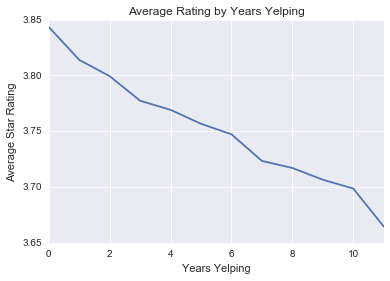

In [22]:
final_user.groupby('Years Yelping').rev_rate.mean().plot(title="Average Rating by Years Yelping").set_ylabel("Average Star Rating")

The longer a user uses yelp  they start giving lower ratings. Let's dig down and see if this is like this accross for our cities. 

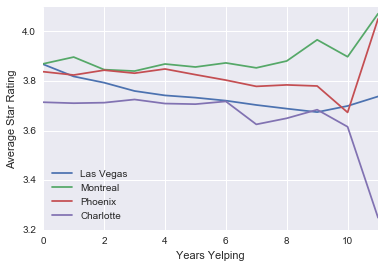

In [23]:
final_user[final_user['city']=='Las Vegas'].groupby('Years Yelping').rev_rate.mean().plot(label='Las Vegas',legend=True).set_ylabel("Average Star Rating")
final_user[final_user['city']=='Montreal'].groupby('Years Yelping').rev_rate.mean().plot(label='Montreal',legend=True)
final_user[final_user['city']=='Phoenix'].groupby('Years Yelping').rev_rate.mean().plot(label='Phoenix',legend=True)
final_user[final_user['city']=='Charlotte'].groupby('Years Yelping').rev_rate.mean().plot(label='Charlotte',legend=True)

With the exception of Montreal and Phoenix, there seems to be a downward correlation with the average rating a longtime user gives a review. Let's see how many users in each category are longtime users

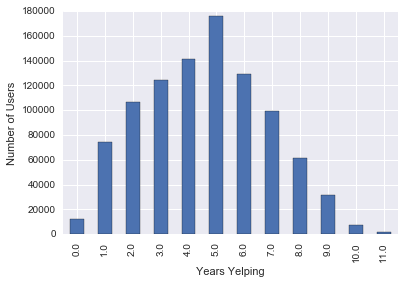

In [24]:
final_user.groupby('Years Yelping').user_id.count().plot(kind='bar').set_ylabel("Number of Users")

### Late Night CheckIn

The checkin dataset was much smaller than the review dataset, so we were able to read in the raw data, containing checkin info from all the cities in the Yelp dataset.
We referred to the Yelp site that hosted the checkin data to understand how to "translate" the data in the checkin_info column. The checkin_info is in dictionary format. The keys are pairs of numbers separated by a dash. The first number is the hour (in military time). The second is the day of the week (starting with 0 for Sunday). The dictionary values are the number of checkins at that business, during that hour, on that day of the week. For example, '14-6':1 refers to one checkin that happened between 2:00 & 3:00 p.m. on a Saturday.

We had to figure out a way to determine how many late night checkins each business had. We decided that checkins that happened between 11 p.m. and 4 a.m. were considered "late night checkins." The function belows tallies the late night checkins and non-late checkings (to account for all checkin data). We applied it to the checkin_info column and added the new column, late_checkins and nonlate_checkins, to the dataset. See below


In [25]:
# One thing to note: I arbitrarily decided late night checkins must happen
# between the hours of 11 p.m. and 3 a.m.

def checkin_translate(d):
    new_keys = []
    late_hours = ['23', '0', '1', '2', '3']
    checkin_total = 0
    for keys in d:
        split_keys = keys.split('-')
        split_keys.append(d[keys])
        new_keys.append(split_keys)
    for elem in new_keys:
        if elem[0] in late_hours:
            checkin_total += elem[2]
    return checkin_total

def checkin_nonlate(d):
    new_keys = []
    late_hours = ['23', '0', '1', '2', '3']
    checkin_total = 0
    for keys in d:
        split_keys = keys.split('-')
        split_keys.append(d[keys])
        new_keys.append(split_keys)
    for elem in new_keys:
        if elem[0] not in late_hours:
            checkin_total += elem[2]
    return checkin_total

checkin_data['late_checkins'] = checkin_data.checkin_info.apply(checkin_translate)
checkin_data['nonlate_checkins'] = checkin_data.checkin_info.apply(checkin_nonlate)

We set the index to business_id and created a CSV file to call in our analysis later on.

In [26]:
checkin_data_modified = checkin_data.set_index('business_id')
checkin_data_modified.to_csv("checkin_with_late_night.csv", index_label='business_id')

#### Total Number of Late Checkins by City

In [27]:
check_in = pd.read_csv("checkin_with_late_night.csv")
city_bus = pd.read_csv("business_data_city.csv",encoding='latin-1')
bus_check=city_bus.merge(check_in,how='inner',on='business_id')

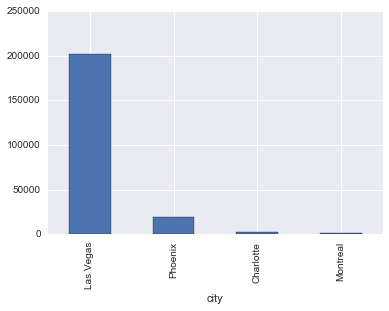

In [28]:
bus_check.groupby('city').late_checkins.sum().sort_values(ascending=False).plot(kind='bar')

In [29]:
late=bus_check.groupby('city').late_checkins.sum()
non_late=bus_check.groupby('city').nonlate_checkins.sum()
total=late+non_late

In [30]:
#This is the proportion of data
late/total

city
Charlotte    0.008677
Las Vegas    0.089501
Montreal     0.013370
Phoenix      0.023875
dtype: float64

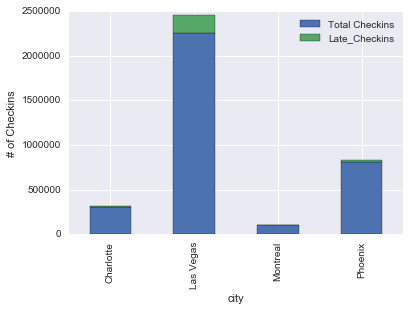

In [31]:
df = pd.DataFrame([total,late]).T
df.columns=['Total Checkins','Late_Checkins']
df.plot(kind='bar',stacked=True).set_ylabel('# of Checkins')

### Kid Friendly

After creating the final review file (final_rest) and distributing it to all group members, we ran into a couple of problems as we split pu the work and tackled parts of the project independently.  The kid-friendly analysis was dependent upon a column whose data type in the raw data was a dictionary.  Somewhere in the merge/append/write to csv process, that column got converted to a string.  So for the purposes of this portion, we went back to the raw data and applied the same logic to normalize the spelling of Montreal & get the restaurant flag.

In [32]:
def mont(city):
    if city == 'Montréal':
        return 'Montreal'
    else:
        return city
business_data['city']=business_data.city.map(mont)

In [33]:
def restaurant_check(l):
    """Takes in a list and looks for keywords to populate a
    flag indicating a Yelp business is a restaurant."""
    
    desired = ['Restaurants','Food','Nightlife','Bars','Fast Food','Mexican',
               'Sandwiches','Pizza','American (Traditional)', 'Coffee & Tea',
               'Burgers','Chinese','Italian','American (New)','Breakfast & Brunch',
               'Specialty Food','Bakeries','Japanese','Cafes',
               'Ice Cream & Frozen Yogurt','Sushi Bars','Desserts','Sports Bars',
               'Seafood','Chicken Wings','Delis','French','Steakhouses','Barbeque',
               'Asian Fusion','Pubs','Mediterranean']
    flag = 0
    for elem in l:
        if elem in desired:
            flag = 1
    return flag
business_data['restaurant_flag'] = business_data.categories.apply(restaurant_check)

In [34]:
def kid_friendly_check(d):
    """Takes a Yelp attributes dictionary as input
    and checks for a specific keywords"""
    votes = 0
    for elem in d:
        if elem == 'Good for Kids':
            if d['Good for Kids'] == True:
                votes = 1
    return votes

business_data['kid_friendly'] = business_data.attributes.apply(kid_friendly_check)

We want to do a quick check to make sure those columns showed up as we intended.

In [35]:
business_data.head()

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type,Restaurant_Check,restaurant_flag,kid_friendly
0,"{'Outdoor Seating': False, 'Good For Groups': ...",5UmKMjUEUNdYWqANhGckJw,"[Fast Food, Restaurants]",Dravosburg,"4734 Lebanon Church Rd\nDravosburg, PA 15034","{'Tuesday': {'close': '21:00', 'open': '11:00'...",40.354327,-79.900706,Mr Hoagie,[],True,4,4.5,PA,business,Yes,1,1
1,"{'Good For Groups': True, 'Accepts Credit Card...",UsFtqoBl7naz8AVUBZMjQQ,[Nightlife],Dravosburg,"202 McClure St\nDravosburg, PA 15034",{},40.350553,-79.886814,Clancy's Pub,[],True,4,3.5,PA,business,Yes,1,0
2,{},3eu6MEFlq2Dg7bQh8QbdOg,"[Auto Repair, Automotive]",Dravosburg,"1 Ravine St\nDravosburg, PA 15034",{},40.350956,-79.889059,Joe Cislo's Auto,[],True,3,5.0,PA,business,None,0,0
3,{'Good for Kids': True},cE27W9VPgO88Qxe4ol6y_g,"[Active Life, Mini Golf, Golf]",Bethel Park,"1530 Hamilton Rd\nBethel Park, PA 15234",{},40.354115,-80.014660,Cool Springs Golf Center,[],False,5,2.5,PA,business,None,0,1
4,"{'Parking': {'garage': False, 'validated': Fal...",HZdLhv6COCleJMo7nPl-RA,"[Shopping, Home Services, Internet Service Pro...",Pittsburgh,"301 South Hills Village\nPittsburgh, PA 15241","{'Thursday': {'close': '17:00', 'open': '10:00...",40.357620,-80.059980,Verizon,[],True,5,2.5,PA,business,None,0,0


Now that we've populated the flags we want, it's time to narrow down the datasets to just the cities we want to look at. Since the cities have very different volumes of businesses in the Yelp dataset, we decided we couldn't directly compare numbers of kid-friendly places. We decided to do it by proportion of kid-friendly restaurants in relation to total number of restaurants. We first looked at each city individually. First up, Las Vegas.

### Las Vegas

In [36]:
biz_Vegas = business_data[(business_data['city'] == 'Las Vegas') & (business_data['restaurant_flag'] == 1)]

In [37]:
LAS_kid_places = biz_Vegas.kid_friendly.sum()
LAS_total = len(biz_Vegas)
LAS_proportion = LAS_kid_places / LAS_total

LAS_proportion

0.5623055267447029

56% of Las Vegas businesses we determined to be restaurants were reviewed on Yelp and deemed 'kid-friendly.' That's more than we expected.  Now we want to figure out how many places are not kid-friendly.

In [38]:
LAS_no_kids = LAS_total - LAS_kid_places
LAS_no_kids

2954

### Phoenix

In [39]:
biz_Phoenix = business_data[(business_data['city'] == 'Phoenix') & (business_data['restaurant_flag'] == 1)]
biz_Phoenix.head()

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type,Restaurant_Check,restaurant_flag,kid_friendly
2216,"{'Outdoor Seating': False, 'Good For Groups': ...",x5Mv61CnZLohZWxfCVCPTQ,"[Sandwiches, Pizza, Chicken Wings, Restaurants]",Phoenix,"2819 N Central Ave\nPhoenix, AZ 85004","{'Thursday': {'close': '00:00', 'open': '10:00...",33.479482,-112.073681,Domino's Pizza,[],True,16,2.5,AZ,business,Yes,1,0
2217,"{'Price Range': 1, 'Good for Kids': True, 'Noi...",2ZnCITVa0abGce4gZ6RhIw,"[American (New), Sandwiches, Restaurants]",Phoenix,"1850 N Central Ave\nPhoenix, AZ 85004",{},33.468547,-112.075085,Viad Tower Restaurants,[],True,6,3.5,AZ,business,Yes,1,1
2218,"{'Smoking': 'outdoor', 'Alcohol': 'full_bar', ...",EmzaQR5hQlF0WIl24NxAZA,"[American (New), Nightlife, Dance Clubs, Resta...",Phoenix,"132 E Washington St\nPhoenix, AZ 85004","{'Thursday': {'close': '03:00', 'open': '09:00...",33.448399,-112.071702,Sky Lounge,[],True,25,2.5,AZ,business,Yes,1,0
2219,"{'Outdoor Seating': True, 'Smoking': 'outdoor'...",SiwN7f0N4bs4ZtPc4yPgiA,"[Bars, Nightlife, Dance Clubs]",Phoenix,"710 N Central Ave\nPhoenix, AZ 85004",{},33.455885,-112.074177,Palazzo,[],True,19,3.0,AZ,business,Yes,1,0
2222,"{'Outdoor Seating': True, 'Good For Groups': T...",KPoTixdjoJxSqRSEApSAGg,"[Thai, Restaurants]",Phoenix,"2631 N Central Ave\nPhoenix, AZ 85004","{'Thursday': {'close': '21:00', 'open': '11:00...",33.477939,-112.073417,Wild Thaiger,[],True,432,3.5,AZ,business,Yes,1,1


In [40]:
biz_Phoenix.loc[2216].attributes

{'Accepts Credit Cards': True,
 'Alcohol': 'none',
 'Ambience': {'casual': False,
  'classy': False,
  'divey': False,
  'hipster': False,
  'intimate': False,
  'romantic': False,
  'touristy': False,
  'trendy': False,
  'upscale': False},
 'Attire': 'casual',
 'Caters': False,
 'Delivery': True,
 'Good For Groups': False,
 'Good for Kids': False,
 'Has TV': False,
 'Noise Level': 'loud',
 'Outdoor Seating': False,
 'Parking': {'garage': False,
  'lot': True,
  'street': False,
  'valet': False,
  'validated': False},
 'Price Range': 2,
 'Take-out': True,
 'Takes Reservations': False,
 'Waiter Service': False,
 'Wheelchair Accessible': True,
 'Wi-Fi': 'no'}

Note the attributes of the first entry. A Domino's Pizza in Phoenix was rated not good for kids. Possible health nut? Maybe. More likely, it's proof that the inferences and analysis sometimes can only be as good as the data that's given. Logically, we'd assume that the 'not good for kids' description is probably inaccurate, but we also don't have any evidence that the rating warrants changing.

In [41]:
PHX_kid_places = biz_Phoenix.kid_friendly.sum()
PHX_total = len(biz_Phoenix)
PHX_proportion = PHX_kid_places / PHX_total

PHX_proportion

0.618796992481203

62% of Phoenix businesses we deemed to be restaurants that were reviewed on Yelp are deemed 'kid-friendly.'

In [42]:
PHX_no_kids = PHX_total - PHX_kid_places
PHX_no_kids

1521

### Charlotte

In [43]:
biz_Charlotte = business_data[(business_data['city'] == 'Charlotte') & (business_data['restaurant_flag'] == 1)]

In [44]:
CLT_kid_places = biz_Charlotte.kid_friendly.sum()
CLT_total = len(biz_Charlotte)
CLT_proportion = CLT_kid_places / CLT_total

CLT_proportion

0.5715393563396666

With 57.1% of restaurants deemed kid-friendly, Charlotte is only slightly more kid-friendly than Las Vegas.  We found that surprising.

In [45]:
CLT_no_kids = CLT_total - CLT_kid_places
CLT_no_kids

1105

### Montreal

In [46]:
biz_Montreal = business_data[(business_data['city'] == 'Montreal') & (business_data['restaurant_flag'] == 1)]

In [47]:
MTL_kid_places = biz_Montreal.kid_friendly.sum()
MTL_total = len(biz_Montreal)
MTL_proportion = MTL_kid_places / MTL_total

MTL_proportion

0.461465271170314

Montreal appears to be the least kid friendly at 46%

In [48]:
MTL_no_kids = MTL_total - MTL_kid_places
MTL_no_kids

1698

In [49]:
df_proportion = pd.DataFrame({'city':['Las Vegas', 'Phoenix', 'Charlotte', 'Montreal'], 'proportion_kid_friendly':
                              [LAS_proportion, PHX_proportion, CLT_proportion, MTL_proportion]}).set_index('city')
df_proportion

,proportion_kid_friendly
city,
Las Vegas,0.562306
Phoenix,0.618797
Charlotte,0.571539
Montreal,0.461465


### Kid-friendly Comparison

In [50]:
compare_df = pd.DataFrame({'City': ['Las Vegas', 'Phoenix', 'Montreal', 'Charlotte'], 'Kid Friendly Places': 
              [LAS_kid_places, PHX_kid_places, MTL_kid_places, CLT_kid_places], 'Not Kid Friendly Places': 
              [LAS_no_kids, PHX_no_kids, MTL_no_kids, CLT_no_kids]})

In [51]:
compare_df.set_index('City', inplace=True)

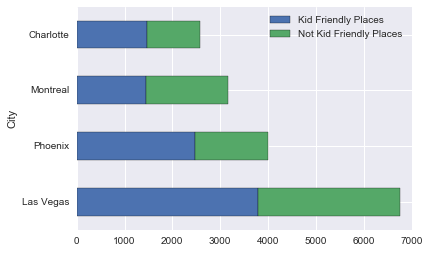

In [52]:
compare_df.plot(kind='barh', stacked=True)

### Hot Spots
From the entire batch of Yelpers, we teased out the best: users who had been given max (4-star) ratings
Using the top-rated Yelpers as our guides, we wanted to infer the best places to find good eats in each city. 

In [83]:
df = pd.read_csv('biz_user.csv')
del df['Unnamed: 0']

In [84]:
def useful(votes):
    if type(votes) == str:
        if 'useful' in votes:      
            position = votes.find(':')
            stop = votes.find(',')
            votes1 = votes[position+2:stop]
            return int(votes1)
    else:
        return int(0)

In [85]:
df['useful'] = df['votes_x'].apply(useful)
df.useful.head()

0      280
1    14199
2    14199
3    14199
4    14199
Name: useful, dtype: int64

We created a rating system based on the number of "useful" votes a user had received and turned it into a star rating, 1 to 4. These stars were based on the quartiles in the data.

In [86]:
df.useful.drop_duplicates().describe()

count     3245.000000
mean      2840.705701
std       4104.572500
min          0.000000
25%        811.000000
50%       1661.000000
75%       3129.000000
max      55937.000000
Name: useful, dtype: float64

In [87]:
def to_stars(useful):
    if useful < 600:
        return 1
    elif 600 <= useful < 1200:
        return 2
    elif 1200 <= useful < 2500:
        return 3
    elif 2500 <= useful < 50000:
        return 4

In [88]:
df['user_stars'] = df['useful'].apply(to_stars)

Top Yelpers: Yelpers who were rated 4.0 stars

We looked at the proportional of high-rated Yelp users to see where they were living. The highest number of top yelpers were in Las Vegas.

In [89]:
df_trusted = pd.DataFrame(df[df.user_stars==4].city.value_counts().sort_values(ascending=False)/df.city.value_counts().sort_values(ascending=False))
df_trusted.std()
df_trusted

,city
Las Vegas,0.039335
Phoenix,0.027651
Charlotte,0.026062
Montreal,0.020660


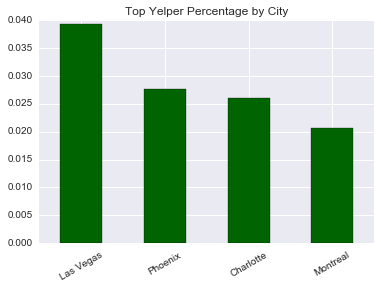

In [90]:
df_trusted.city.plot(kind='bar', color='DarkGreen', rot=30,title='Top Yelper Percentage by City',legend=False)

In looking at the neighborhoods, I wanted to clear up the lists in the neighborhoods column.
I also wanted to clear up some names with unique letters, especially in the top 10 neighborhoods of Montreal.

In [91]:
def clear_neighb(neighborhood):
        return str(neighborhood).strip('[]' + "'")

df.neighborhoods = df.neighborhoods.apply(clear_neighb)

In [92]:
def fix_mont_neighb(neighborhood):
    if neighborhood == str('CÌ«te-des-Neiges'):
        return str('Cote-des-Neiges')
    elif neighborhood == str('Notre-Dame-de-GrÌ¢ce'):
        return str('Notre-Dame-de-Grace')
    else:
        return neighborhood

df.neighborhoods = df.neighborhoods.apply(fix_mont_neighb)

## What are the neighborhoods with the highest-density of popular eateries in each city, by Top Users?
For travelers, it's important to note which locations have a higher density of 5-star locales.

In order to rate the top 5 eateries in each city, we wanted to take into account the following parameters.
We wanted to guarantee that the reviews were being provided by the most trusted users (stars_x = 5.0), and that they were scoring these places high (stars_y = 5.0). We also wanted to take into account the number of people that had rated these restaurants, which is why the review_count_x is summed.

## Montreal: Eateries and Neighborhoods

/Users/melaniecostello/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


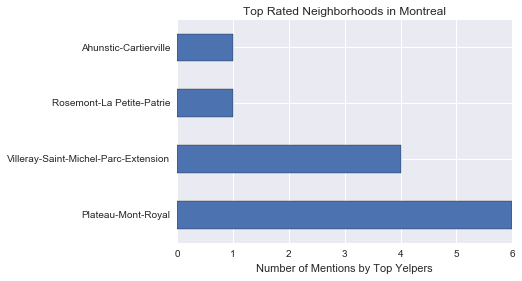

In [93]:
ax = df[df.user_stars==4][df.city=='Montreal'][df.stars_y==5.0].neighborhoods.value_counts().sort_values(ascending=False)[:5].plot(kind='barh',title='Top Rated Neighborhoods in Montreal')
ax.set_xlabel('Number of Mentions by Top Yelpers')
ax

In [94]:
df = df.rename(columns={'name':'name_y', 'review_count':'review_count_x'})

/Users/melaniecostello/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


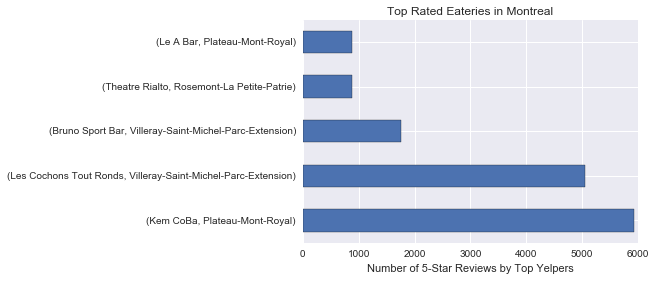

In [95]:
ax = df[df.user_stars==4][df.city=='Montreal'][df.stars_y==5.0].groupby(['name_y','neighborhoods']).review_count_x.sum().sort_values(ascending=False)[:5].plot(kind='barh',title='Top Rated Eateries in Montreal')
ax.set_xlabel('Number of 5-Star Reviews by Top Yelpers')
ax.set_ylabel('')
ax

## Las Vegas: Eateries and Neighborhoods

/Users/melaniecostello/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


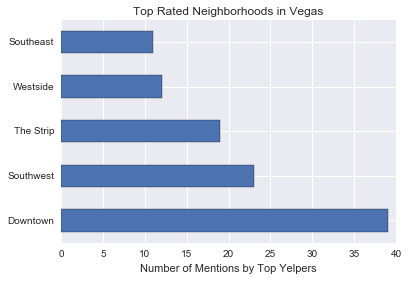

In [96]:
ax = df[df.user_stars==4][df.city=='Las Vegas'][df.neighborhoods!=''][df.stars_y==5.0].neighborhoods.value_counts().sort_values(ascending=False)[:5].plot(kind='barh',title='Top Rated Neighborhoods in Vegas')
ax.set_xlabel('Number of Mentions by Top Yelpers')
ax

/Users/melaniecostello/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


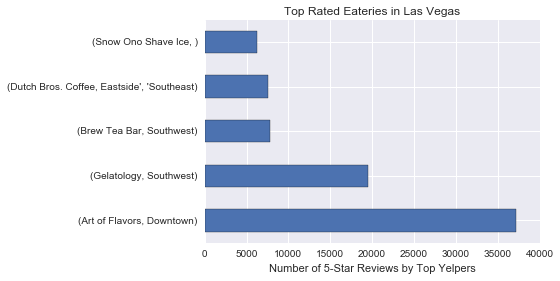

In [97]:
ax = df[df.user_stars==4][df.city=='Las Vegas'][df.stars_y==5.0][df.name_y!='Boyz II Men'].groupby(['name_y','neighborhoods']).review_count_x.sum().sort_values(ascending=False)[:5].plot(kind='barh',title='Top Rated Eateries in Las Vegas')
ax.set_xlabel('Number of 5-Star Reviews by Top Yelpers')
ax.set_ylabel('')
ax

## Charlotte: Eateries and Neighborhoods

/Users/melaniecostello/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


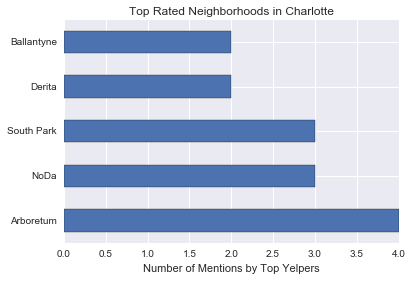

In [98]:
ax = df[df.user_stars==4][df.city=='Charlotte'][df.neighborhoods!=''][df.stars_y==5.0].neighborhoods.value_counts().sort_values(ascending=False)[:5].plot(kind='barh',title='Top Rated Neighborhoods in Charlotte')
ax.set_xlabel('Number of Mentions by Top Yelpers')
ax

/Users/melaniecostello/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


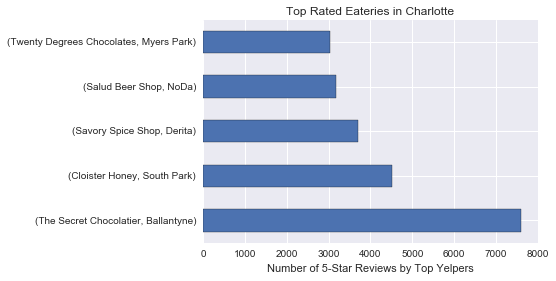

In [99]:
ax = df[df.user_stars==4][df.city=='Charlotte'][df.stars_y==5.0].groupby(['name_y','neighborhoods']).review_count_x.sum().sort_values(ascending=False)[:5].plot(kind='barh',title='Top Rated Eateries in Charlotte')
ax.set_xlabel('Number of 5-Star Reviews by Top Yelpers')
ax.set_ylabel('')
ax

## Phoenix: Eateries
We will point out that Phoenix was not sectioned into neighborhoods. Tempe and Scottscale, which could be considered suburbs of Phoenix, were listed as separate cities, and were not included in our analysis.

/Users/melaniecostello/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


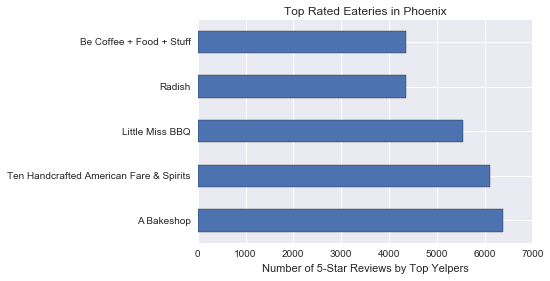

In [100]:
ax = df[df.user_stars==4][df.city=='Phoenix'][df.stars_y==5.0].groupby(['name_y']).review_count_x.sum().sort_values(ascending=False)[:5].plot(kind='barh',title='Top Rated Eateries in Phoenix')
ax.set_xlabel('Number of 5-Star Reviews by Top Yelpers')
ax.set_ylabel('')
ax

## User Info: Who are the most active users, newer or older Yelpers?

In looking at the overall activity of Yelp users, we found that the most active users were neither the oldest nor the youngest yelp users, but rather those that had joined between 5 - 6 years ago.
This is helpful, because we can be assured that the majority of reviews are coming from experienced people.
I created a separate column to look at the year individuals started Yelping.

In [101]:
def yelp_year(when):
    return str(when)[:4]

df['yelping_since_year'] = df['yelping_since'].apply(yelp_year)

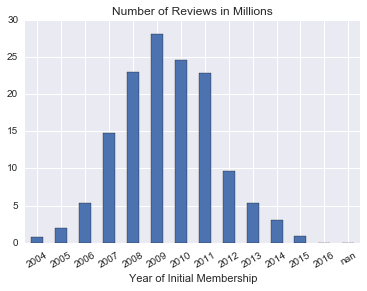

In [102]:
ax = ((df.groupby('yelping_since_year').review_count_x.sum())/int(1000000)).plot(kind='bar',rot=30,title='Number of Reviews in Millions')
ax.set_xlabel('Year of Initial Membership')